In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils.mea_analysis as mea
from sklearn.decomposition import PCA
import seaborn as sns
import re
import os

## Todo:

- implement functional channel removal on plotting and pca
- look at attractive region with only good channels in pca plots
- try to do some cluster analysis on that

- add different colours for each channel for voltage plot

In [2]:
vdf = pd.read_csv("example_data/MEA002_postS_50V_V.csv",skiprows=22, sep="\t") #import 14-dimensional voltage data
smudf = pd.read_csv("example_data/MEA002_postS_50V_SMU.csv",skiprows=21, sep="\t") #import current/conductance data
basepath = "example_data/MEA002_postS_50V_SMU.csv"

vdf = vdf.drop(vdf.index[46000:])
smudf = smudf.drop(smudf.index[230:])

In [3]:
smudf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 230 entries, 0 to 229
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X_Value   230 non-null    float64
 1   Untitled  230 non-null    float64
 2   Comment   0 non-null      float64
dtypes: float64(3)
memory usage: 7.2 KB


In [4]:
vcols = []
for header in list(vdf):
    header = header.replace("Voltage_", "v")
    header = header.replace("Untitled", "current")
    header = header.replace("X_Value", "time")
    vcols.append(header)
vdf.columns = vcols
vdf["trel"] = vdf.time - vdf.time.iloc[0]
vdf.trel = pd.to_numeric(vdf.trel)
vdf = vdf.drop(['Comment'], axis=1)

smucols = []
for header in list(smudf):
    header = header.replace("Untitled", "current")
    header = header.replace("X_Value", "time")
    smucols.append(header)
smudf.columns = smucols
smudf["trel"] = smudf.time - smudf.time.iloc[0]
smudf.trel = pd.to_numeric(smudf.trel)
smudf = smudf.drop(['Comment'], axis=1)

V = False
if not (re.search("(\d+)V", basepath)):
     V = int(re.search("(\d+)mV", basepath).group(1))
elif not (re.search("(\d+)mV", basepath)):
        V = int(re.search("(\d+)V", basepath).group(1))
else:
    print("ERROR:couldnt detect conduction")
    print(basepath)
if V:
    smudf["voltage"] = V
    g0 = 7.75e-5  # quantum conductance
    smudf["conductance"] = smudf.current / smudf.voltage / g0

In [ ]:
print(vdf.info())
print(smudf.info())
print(vdf.head())
print(smudf.head())

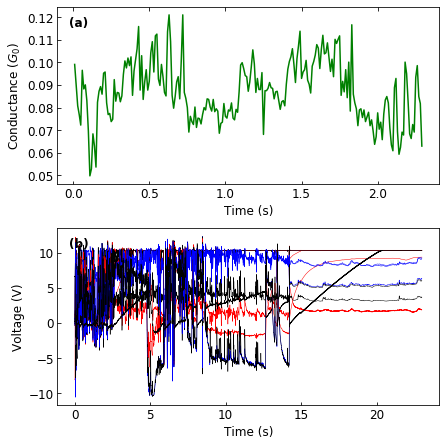

In [5]:
mea.plot_signal(vdf,smudf,show=True)

In [6]:
dg, iei =mea.analyze_events(smudf,gthresh=0.01)

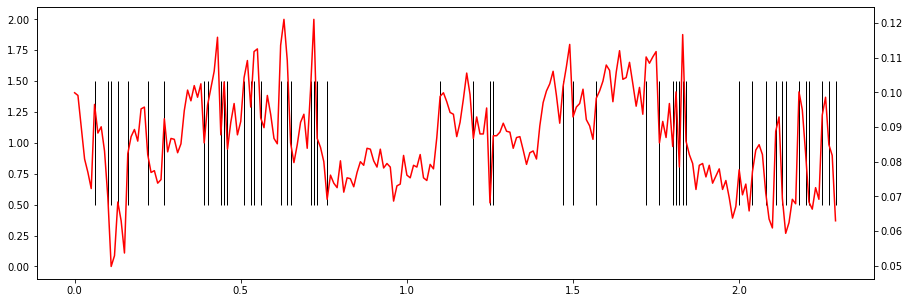

In [7]:
fig, ax = plt.subplots(nrows=1,figsize=(15,5))
ax.eventplot(dg[:,1],linewidth=1,color='k')
ax2=ax.twinx()
ax2.plot(smudf.trel,smudf.conductance,'r')

Text(0.5, 1.0, 'loglog interevent interval length histogram')

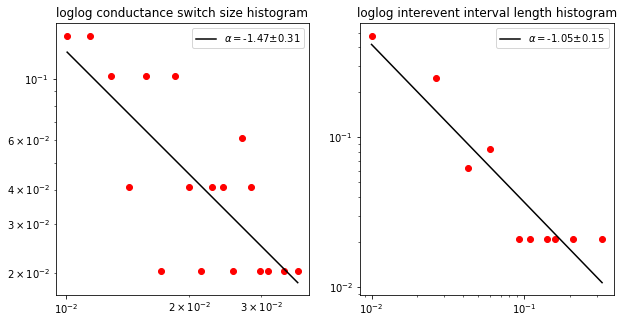

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(10,5))
mea.plot_loglog(dg[:,0],axes[0])
mea.plot_loglog(iei,axes[1])
axes[0].set_title("loglog conductance switch size histogram")
axes[1].set_title("loglog interevent interval length histogram")

In [9]:
resd_all = vdf.iloc[:,3:-1].to_numpy()

In [34]:
print(resd_all.shape)
print(resd_all.ndim)
print(resd_all.size)

(23000, 14)
2
322000


In [35]:
for m in range(14):
    print(resd[2,m])

0.213246
0.5423279999999999
-0.186162
-8.073895
1.1680110000000001
-0.126891
-0.073719
-0.346453
0.605088
-0.083467
-0.317565
-0.289481
0.227255
6.62056


In [41]:
faulty_channels = [] #removing unwanted voltage channels from PCA process
resd = np.delete(resd, obj=[], axis=1) 

In [42]:
print(resd.shape)
print(resd.ndim)
print(resd.size)

(1000, 8)
2
8000


In [43]:
starttime = 10000 #start time of time-scale of interest in ms
endtime = 11000 #end time of time-scale of in in ms
resd = resd[starttime:endtime]
mea.plot_principal_components(resd, displaynan = [], show = True, ends = True)
imgname = os.path.basename(basepath)[:-4]
plt.savefig(f"plots/{imgname}_{starttime/1000:0.0f}-{endtime/1000:0.0f}s.png")

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### Manual PCA exploration

For neds ongoing python education: making a class and doing some stuff with methods and attributes

In [ ]:
class dog:
    def __init__(self, color): # this is a special method because of the __ or dunder method
        """ gets run whenever you make a new dog"""
        self.color = color #this sets color as the value for the attribute
        print(f"making a {self.color} dog")
        
    def bark(self): # this is a method, methods are functions that are attached to objects
        print(f"woof {self.color}")

In [ ]:
d = dog('black')
e = dog('white')
d.bark()
d.color='green'
d.bark()

In [ ]:
# This step is VITAL for reasonable PCA. without some form of normalization pca is pretty odd.
# resd is the original data
# resd is an np array where each column is a dimension (voltage channel)
# and each row is a measurement of all dimensions (voltage at a time)
# normalise resd, to make PCA play nice
# can normalise in a number of ways, eg normalise by the whole dataset mean etc
resd = np.array([(point - point.mean()) / point.mean() for point in resd])

In [ ]:


# from sklearn.decomposition import PCA
# instantiating a PCA oject
pca = PCA()


# perform the fit method of the pca object using our normalised data
pca.fit(resd)
# fit just refers to finding the pricipal components and score that "fit" your specific data (resd)


In [ ]:
pc = pca.components_ # attribute of the pca object after we have done fit

In [ ]:
pc.shape # 14 by 14 vector, with rows = components, and columns = number of dimensions of input data

#### principal component manual exploration

In [ ]:
# first 14d normalised vector
resd[0]

In [ ]:
# first two principal component vectors.
# eg. 0th row, all columns = [0,:] etc.
pc1 = pc[0, :]
pc2 = pc[1, :]

In [ ]:
# projection of the first normalized vector of original vector onto first and second pc. 
# to what is this vector represented by each pc
resd[0].dot(pc1), resd[0].dot(pc2)

In [ ]:
# matrix multiplication of the first two pc vectors with the first data vector
resd[0].dot(pc[:2,:].T)

In [ ]:
# doing the matrix mult, with the first two pc, and the whole matrix of (n, 14) resd matrix
# (n, 14).(14,2) -> (n,2)
projection = resd.dot(pc[:2,:].T)

In [ ]:
plt.scatter(projection[:,0], projection[:,1], alpha=0.2)
# plt.xlim((0,200))
# plt.ylim((-10,59))

In [ ]:
sns.kdeplot(projection[:,0], projection[:,1], shade=True)